In [2]:
import numpy as np
import cv2
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout,  BatchNormalization , Activation
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import load_model
import vis ## keras-vis
from vis.utils import utils
from keras.applications.imagenet_utils import preprocess_input ,decode_predictions
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

Using TensorFlow backend.


In [11]:
model = tf.keras.models.load_model('final-resnet.h5')

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [140]:
test_x = np.load('testx.npy')

In [141]:
test_y = np.load('testy.npy')

In [142]:
test_y = keras.utils.to_categorical(test_y, 3)

In [143]:
image = test_x[0]

In [144]:
# Load pre-trained Keras model and the image to classify
img_tensor = np.expand_dims(image, axis=0)
img_tensor = preprocess_input(img_tensor)

conv_layer = model.get_layer("conv5_block3_3_conv")
heatmap_model = tf.keras.models.Model([model.inputs], [conv_layer.output, model.output])

# Get gradient of the winner class w.r.t. the output of the (last) conv. layer
with tf.GradientTape() as gtape:
    conv_output, predictions = heatmap_model(img_tensor)
    loss = predictions[:, np.argmax(predictions[0])]
    grads = gtape.gradient(loss, conv_output)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
heatmap = np.maximum(heatmap, 0)
max_heat = np.max(heatmap)
if max_heat == 0:
    max_heat = 1e-10
heatmap /= max_heat

print(heatmap.shape)

(1, 10, 10)


In [145]:
x = image[None,:,:,:]

In [146]:
img = Image.fromarray(x[0,:,:,:])

In [155]:
cv2.imwrite('gradcam-test-image.jpg', test_x[0])

True

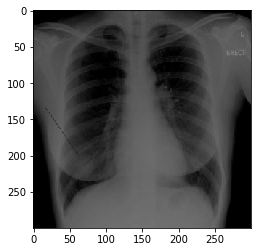

In [147]:
plt.imshow(img)

In [148]:
heatmap = heatmap.reshape((heatmap.shape[1],heatmap.shape[1]))

In [149]:
heatmap = cv2.resize(heatmap, (300,300))

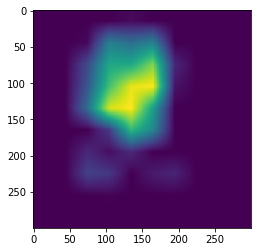

In [150]:
plt.imshow(heatmap)

In [151]:
heatmap= cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

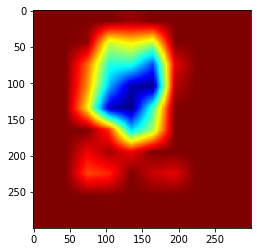

In [152]:
plt.imshow(heatmap)

In [153]:
img = heatmap*0.5 + img

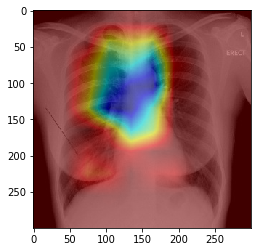

In [154]:
plt.imshow(img.astype(np.uint8))
plt.show()

In [157]:
cv2.imwrite('gradcam.jpg', img.astype(np.uint8))

True